/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 사용 장치: cuda (RTX 2060 확인)
✅ TinyLlama 모델 로드 완료!

🔹 입력 문장: The cat sits
🔹 변환된 토큰: ['<s>', '▁The', '▁cat', '▁s', 'its']
🔹 정수 ID 값: [1, 450, 6635, 269, 1169]

🔹 임베딩 벡터 형태(Shape): torch.Size([1, 5, 2048])

📸 결과 이미지가 저장되었습니다: ../results/01_embedding_heatmap.png


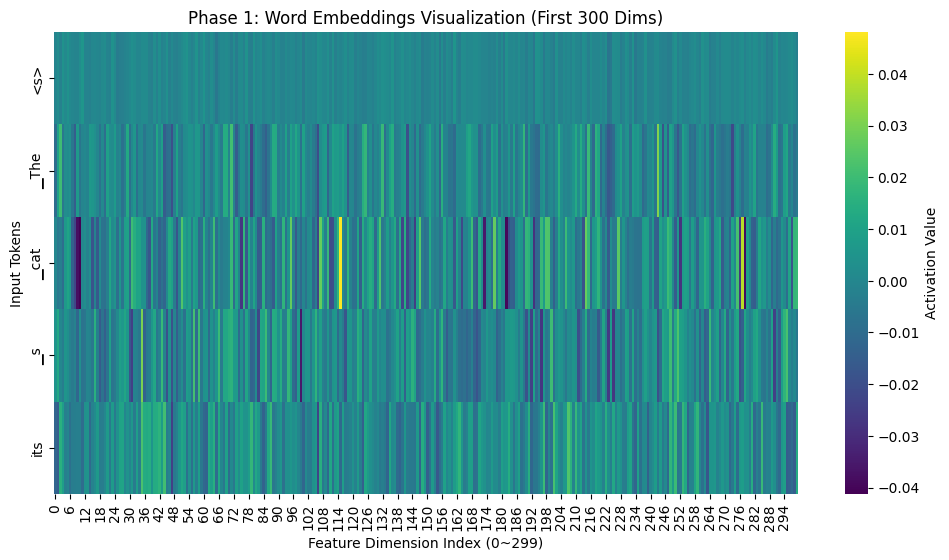

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 0. 결과 저장용 폴더 확인 (없으면 자동 생성)
if not os.path.exists('../results'):
    os.makedirs('../results')

# 1. 모델 로딩 (GPU 가속 확인)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ 사용 장치: {device} (RTX 2060 확인)")

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

print("✅ TinyLlama 모델 로드 완료!")

# 2. 실험할 문장 입력
text = "The cat sits"
inputs = tokenizer(text, return_tensors="pt").to(device)

# 3. 토큰 ID 확인 (글자 -> 숫자)
token_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(token_ids)
# SentencePiece의 특수문자( ) 제거 (가독성 위함)
tokens = [t.replace(' ', '') for t in tokens]

print(f"\n🔹 입력 문장: {text}")
print(f"🔹 변환된 토큰: {tokens}")
print(f"🔹 정수 ID 값: {token_ids.tolist()}")

# 4. 임베딩 벡터 추출 (숫자 -> 고차원 벡터)
# 모델의 맨 앞단인 'embed_tokens' 레이어만 통과시킵니다.
with torch.no_grad():
    embedding_vectors = model.model.embed_tokens(inputs["input_ids"])

print(f"\n🔹 임베딩 벡터 형태(Shape): {embedding_vectors.shape}")
# 결과: [1, 5, 2048] -> [배치1개, 단어5개, 특징2048개]

# 5. 시각화 (바코드처럼 표현된 단어의 의미)
plt.figure(figsize=(12, 6))

# GPU 데이터를 CPU로 가져와서 numpy로 변환
data_to_plot = embedding_vectors[0].cpu().numpy()

# 2048개 차원은 너무 기니까, 앞쪽 300개만 잘라서 패턴을 봅니다.
sns.heatmap(data_to_plot[:, :300], cmap="viridis", yticklabels=tokens, cbar_kws={'label': 'Activation Value'})

plt.title("Phase 1: Word Embeddings Visualization (First 300 Dims)")
plt.xlabel("Feature Dimension Index (0~299)")
plt.ylabel("Input Tokens")

# 6. 결과 이미지 저장 (깃허브용)
save_path = "../results/01_embedding_heatmap.png"
plt.savefig(save_path)
print(f"\n📸 결과 이미지가 저장되었습니다: {save_path}")

plt.show()